# Decision Tree with Lag + Moving Average Features
Enhanced Feature Engineering for CO Classification (4 Horizons)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = (6,4)
HORIZONS=[1,6,12,24]
TARGET="CO(GT)"


## 1. Load Train / Val / Test Sets

In [2]:

train=pd.read_csv("data/splits/airq_train.csv",parse_dates=["timestamp"])
val=pd.read_csv("data/splits/airq_val.csv",parse_dates=["timestamp"])
test=pd.read_csv("data/splits/airq_test.csv",parse_dates=["timestamp"])


## 2. Drop NMHC(GT) + Add Time Features

In [3]:

for df in (train,val,test):
    if "NMHC(GT)" in df.columns:
        df.drop(columns=["NMHC(GT)"],inplace=True)

    df["hour"]=df["timestamp"].dt.hour
    df["weekday"]=df["timestamp"].dt.weekday
    df["month"]=df["timestamp"].dt.month


## 3. Add Lag Features + Moving Averages

In [4]:

def add_lag_ma(df, base_cols, lags, mas):
    df=df.sort_values("timestamp").copy()
    for col in base_cols:
        for h in lags:
            df[f"{col}_lag_{h}"]=df[col].shift(h)
        for w in mas:
            df[f"{col}_ma_{w}"]=df[col].rolling(window=w).mean()
    return df

lag_hours=[1,6,12,24]
ma_windows=[3,6,12,24]
pollutants=[TARGET]

train=add_lag_ma(train, pollutants, lag_hours, ma_windows)
val=add_lag_ma(val, pollutants, lag_hours, ma_windows)
test=add_lag_ma(test, pollutants, lag_hours, ma_windows)


## 4. Create Horizon Targets

In [5]:

def discretise_co(s):
    return pd.cut(s, bins=[-np.inf,1.5,2.5,np.inf], labels=["low","mid","high"])

def add_targets(df):
    df=df.sort_values("timestamp").copy()
    for h in HORIZONS:
        shifted=df[TARGET].shift(-h)
        df[f"y_{h}h"]=discretise_co(shifted)
    return df

train=add_targets(train)
val=add_targets(val)
test=add_targets(test)


## 5. Build X / y Function

In [6]:

def build_xy(df,h):
    ycol=f"y_{h}h"
    df2=df.dropna(subset=[ycol]).copy()
    y=df2[ycol]
    drop_cols=["timestamp"]+[f"y_{k}h" for k in HORIZONS]
    X=df2[[c for c in df2.columns if c not in drop_cols]]
    return X,y


## 6. Train + Evaluate Decision Tree per Horizon

Horizon: 1 hour(s) ahead
Val accuracy: 0.6861313868613139
Test accuracy: 0.7594752186588921
Baseline accuracy: 0.7518518518518519


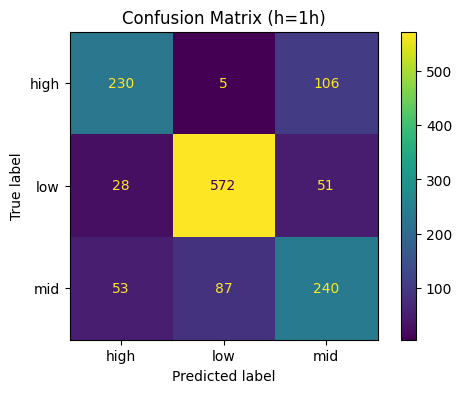

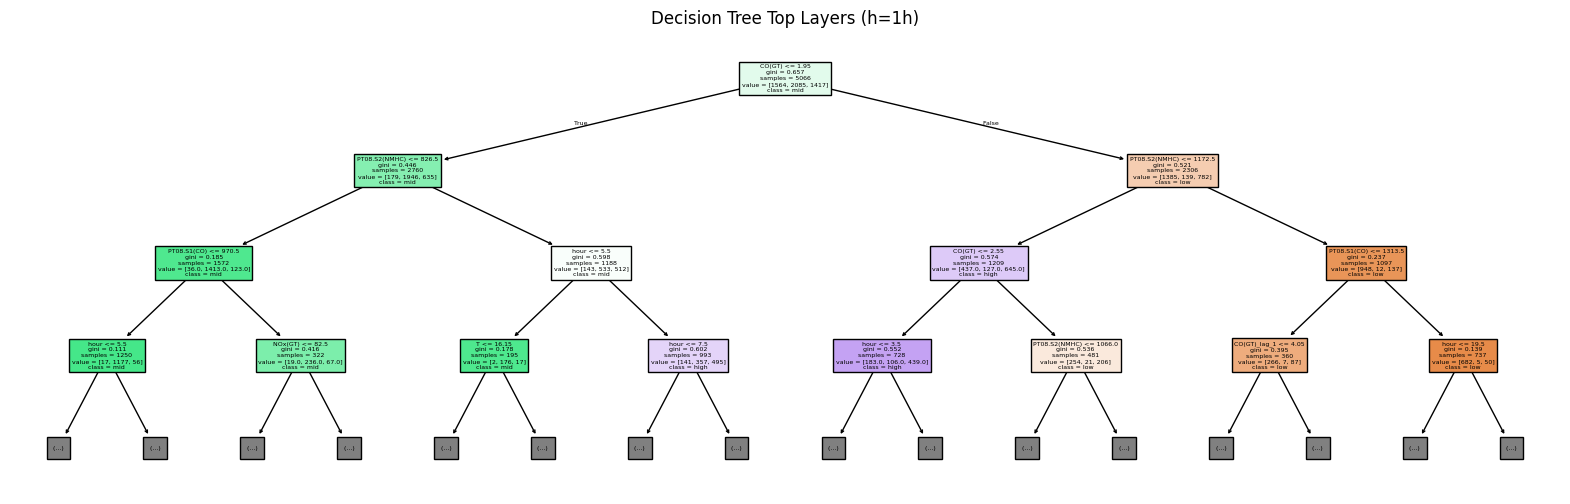

Horizon: 6 hour(s) ahead
Val accuracy: 0.5203583061889251
Test accuracy: 0.5640087783467447
Baseline accuracy: 0.3724756918474196


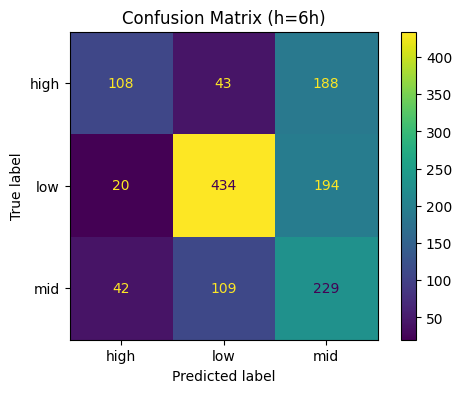

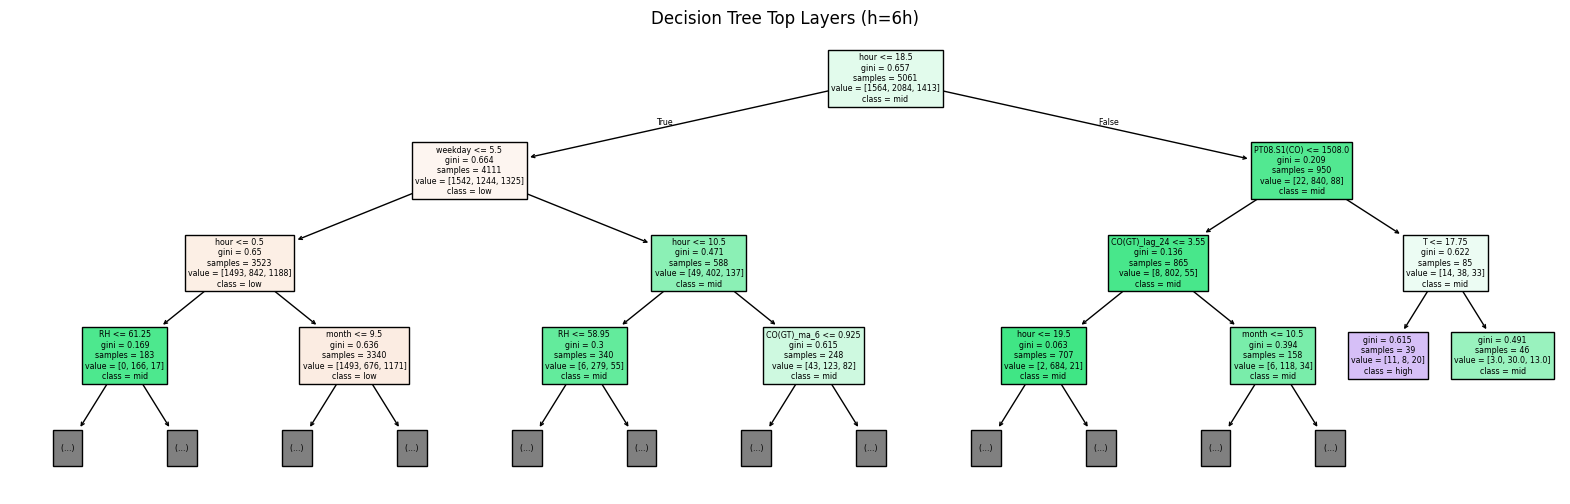

Horizon: 12 hour(s) ahead
Val accuracy: 0.5540098199672667
Test accuracy: 0.6318883174136665
Baseline accuracy: 0.4009009009009009


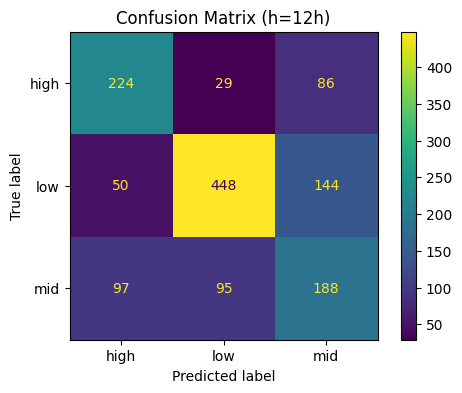

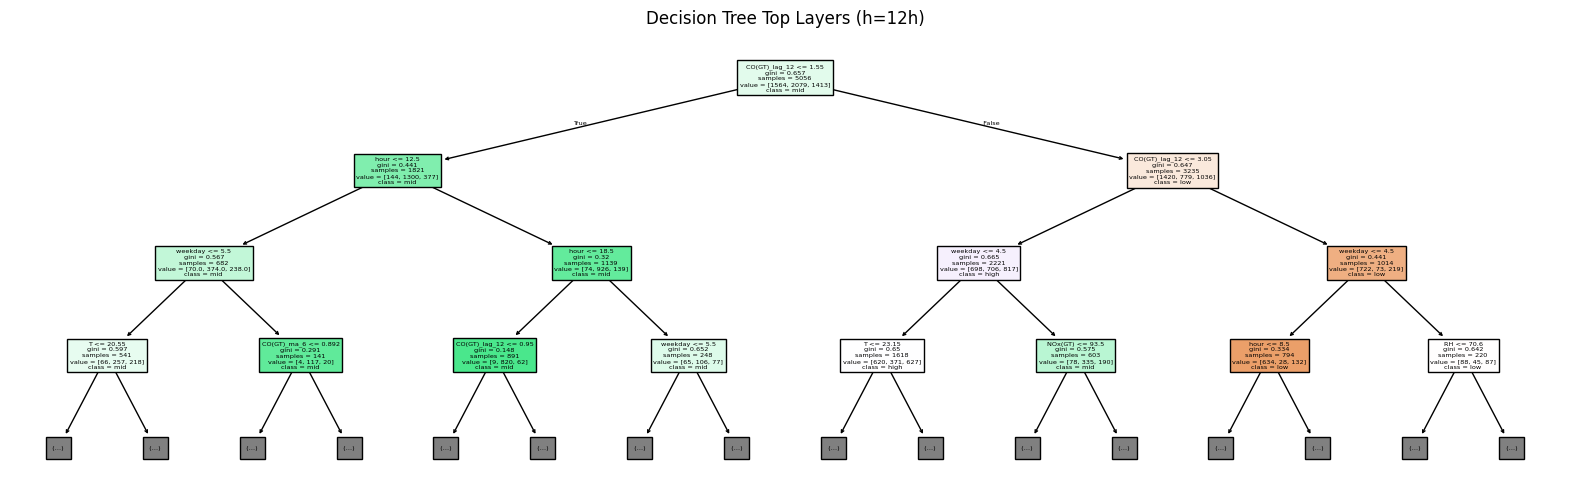

Horizon: 24 hour(s) ahead
Val accuracy: 0.5347107438016528
Test accuracy: 0.5441067457375834
Baseline accuracy: 0.6274509803921569


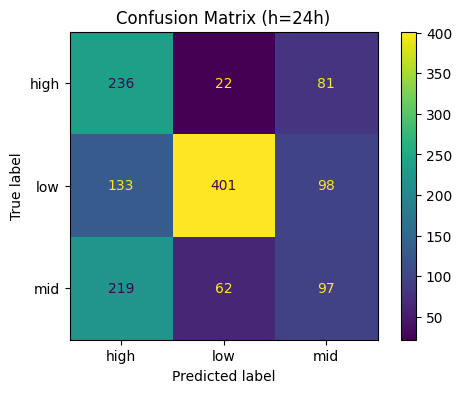

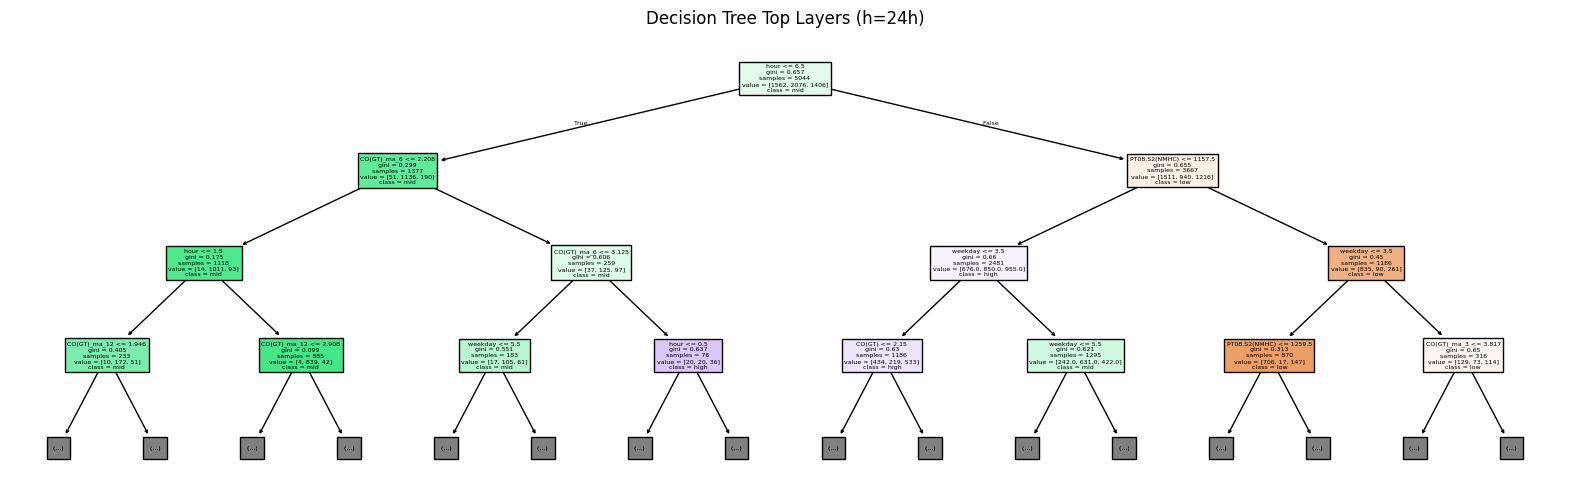

In [7]:

def run_model(h, depth=7, leaf=30):
    print("="*60, "\nHorizon:",h,"hour(s) ahead")

    Xtr,ytr=build_xy(train,h)
    Xv,yv=build_xy(val,h)
    Xte,yte=build_xy(test,h)

    pipe=Pipeline([
        ("imp",SimpleImputer(strategy="median")),
        ("clf",DecisionTreeClassifier(max_depth=depth,min_samples_leaf=leaf,random_state=42))
    ])

    pipe.fit(Xtr,ytr)

    print("Val accuracy:", accuracy_score(yv, pipe.predict(Xv)))

    pred=pipe.predict(Xte)
    print("Test accuracy:", accuracy_score(yte,pred))

    # baseline
    co_now=test.loc[Xte.index, TARGET]
    base_pred=discretise_co(co_now)
    mask=base_pred.notna()
    print("Baseline accuracy:", accuracy_score(yte[mask], base_pred[mask]))

    ConfusionMatrixDisplay.from_predictions(yte,pred)
    plt.title(f"Confusion Matrix (h={h}h)")
    plt.show()

    plt.figure(figsize=(20,6))
    plot_tree(pipe.named_steps["clf"],
              feature_names=Xtr.columns,
              class_names=["low","mid","high"],
              filled=True,
              max_depth=3)
    plt.title(f"Decision Tree Top Layers (h={h}h)")
    plt.show()


for h in HORIZONS:
    run_model(h)


## 6. Accuracy improvement DT − baseline

Decision Tree test accuracy: {1: 0.7594752186588921, 6: 0.5640087783467447, 12: 0.6318883174136665, 24: 0.5441067457375834}
Baseline accuracy: {1: 0.7518518518518519, 6: 0.3724756918474196, 12: 0.4009009009009009, 24: 0.6274509803921569}


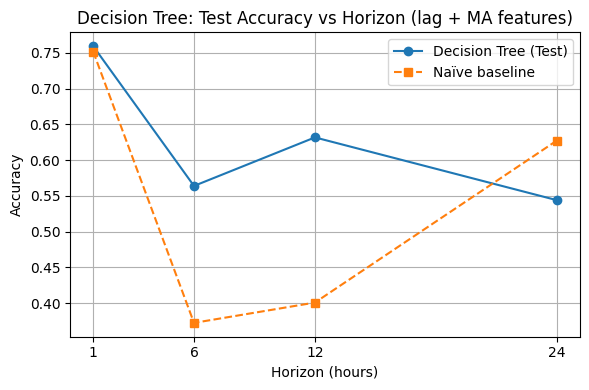

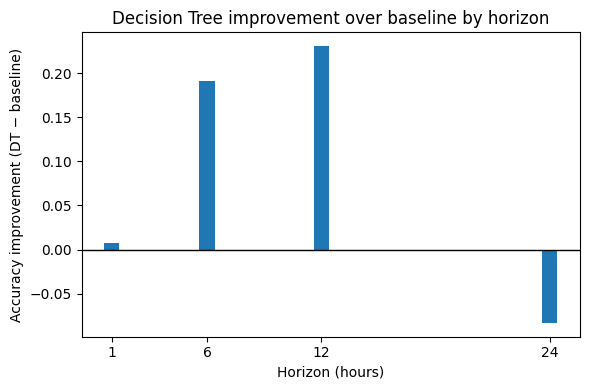

In [ ]:
dt_acc = {}
baseline_acc = {}

for h in HORIZONS:

    Xtr, ytr = build_xy(train, h)
    Xv,  yv  = build_xy(val,   h)
    Xte, yte = build_xy(test,  h)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", DecisionTreeClassifier(max_depth=7, 
                                       min_samples_leaf=30,
                                       random_state=42))
    ])

    # 训练
    pipe.fit(Xtr, ytr)

    # Decision Tree 测试集准确率
    pred_test = pipe.predict(Xte)
    dt_acc[h] = accuracy_score(yte, pred_test)

    # baseline: y(t+h) ← y(t)
    co_now = test.loc[Xte.index, TARGET]
    base_pred = discretise_co(co_now)
    mask = base_pred.notna()
    baseline_acc[h] = accuracy_score(yte[mask], base_pred[mask])


horizons = HORIZONS
dt_list = [dt_acc[h] for h in horizons]
baseline_list = [baseline_acc[h] for h in horizons]

print("Decision Tree test accuracy:", dt_acc)
print("Baseline accuracy:", baseline_acc)


plt.figure()
plt.plot(horizons, dt_list, marker="o", label="Decision Tree (Test)")
plt.plot(horizons, baseline_list, marker="s", linestyle="--", label="Naïve baseline")
plt.xlabel("Horizon (hours)")
plt.ylabel("Accuracy")
plt.title("Decision Tree: Test Accuracy vs Horizon (lag + MA features)")
plt.xticks(horizons)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

improvement = [dt_list[i] - baseline_list[i] for i in range(len(horizons))]

plt.figure()
plt.bar(horizons, improvement)
plt.axhline(0, linewidth=1, color="black")
plt.xlabel("Horizon (hours)")
plt.ylabel("Accuracy improvement (DT − baseline)")
plt.title("Decision Tree improvement over baseline by horizon")
plt.xticks(horizons)
plt.tight_layout()
plt.show()